# Notebook for downloading and preparing data
This notebook downloads labeled datasets and prepares them for training. The code is mostly copied from https://github.com/RSchmirler/data-repo_plm-finetune-eval with small adaptations where necessary. 

In [95]:
# Define the function to download and prepare data from FLIP repository
import requests
import zipfile
from io import BytesIO
import pandas as pd

def download_data(url, file_name, keep_columns = ["sequence","label"]):
    """Download and prepare data from a zipped CSV file."""
    # Download the zip file
    response = requests.get(url)
    zip_file = zipfile.ZipFile(BytesIO(response.content))
    with zip_file.open(file_name) as file:
        df = pd.read_csv(file)
    # Rename 'target' column to 'label'
    df = df.rename(columns={"target":"label"})

    # Split the data into train, validation, and test sets
    test = df[df.set=="test"]
    train_valid_df = df[df.set!="test"].reset_index(drop=True)

    train=train_valid_df[train_valid_df.validation!=True].reset_index(drop=True)
    valid=train_valid_df[train_valid_df.validation==True].reset_index(drop=True)

    if keep_columns is not None:
        return train[keep_columns], valid[keep_columns], test[keep_columns]
    return train, valid, test

# Sequence Regression Example Data Preparation 
GB1 dataset from https://github.com/J-SNACKKB/FLIP

"The GB1 "four" variations set stems from a 2016 publication in which mutations at four sites (V39, D40, G41 and V54) were probed against a binding assay. The full WT GB1 sequence was never included in the dataset, so it was inferred from side chain A of PDB's 5LDE.

`three_vs_rest`: `train` is wild type, all single, double & triple mutations, `test` is everything else."

The continuous label is the log enrichment score from the binding assay. Higher scores indicate better fitness. 

In [96]:
# Download GB1 dataset
GB1_URL = 'https://github.com/J-SNACKKB/FLIP/raw/main/splits/gb1/splits.zip'
GB1_FILENAME = 'splits/three_vs_rest.csv'
GB1_train_df, GB1_valid_df, GB1_test_df = download_data(GB1_URL, GB1_FILENAME)

train dataset size 5382
validation dataset size: 598
test dataset size: 11486


,sequence,label
0,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.000000
1,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIDGEWTYD...,1.445905
2,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGLDGEWTYD...,1.690164
3,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGMDGEWTYD...,1.170550
4,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVAGEWTYD...,2.401243


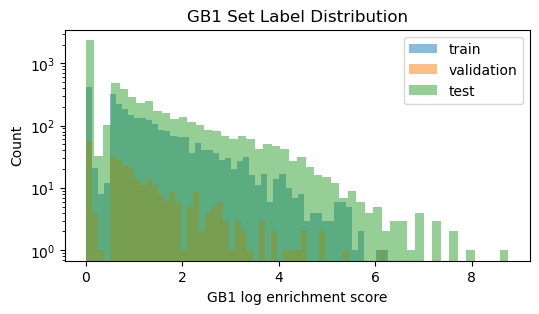

In [97]:
# Dataset info

# Print dataset info
print("train dataset size", GB1_train_df.size)
print("validation dataset size:", GB1_valid_df.size)
print("test dataset size:", GB1_test_df.size)

# Visualize label distribution
from matplotlib import pyplot as plt
plt.figure(figsize=(6,3))
plt.hist(GB1_train_df.label, bins=50, alpha=0.5, label='train')
plt.hist(GB1_valid_df.label, bins=50, alpha=0.5, label='validation')
plt.hist(GB1_test_df.label, bins=50, alpha=0.5, label='test')
plt.legend()
plt.yscale("log")
plt.xlabel("GB1 log enrichment score")
plt.ylabel("Count")
plt.title("GB1 Set Label Distribution")

# Show first few rows of training data
GB1_train_df.head()

In [98]:
# Save prepared data to CSV files
import os
os.makedirs("training_data/gb1", exist_ok=True)
GB1_train_df.to_csv("training_data/gb1/gb1_seq_regression_train.csv",index=False)
GB1_valid_df.to_csv("training_data/gb1/gb1_seq_regression_validation.csv",index=False)
GB1_test_df.to_csv("training_data/gb1/gb1_seq_regression_test.csv",index=False)

# Sequence Regression Example Data Preparation 2

AAV fitness dataset from https://github.com/J-SNACKKB/FLIP/tree/main/splits/aav
We use two_vs_many split. 

The dataset comes from Ogden et al., 2019 (Nature Biotechnology), who performed a deep mutational scan (DMS) on the AAV2 capsid protein (UniProt P03135).
The label reflects the log2 of the enrichment ratio from a viral production assay, where higher values indicate better fitness.

"
The original sequence from the aav study is UniProt P03135. A copy of the wildtype sequence can be found in this folder as P03135.fasta On the reference sequence, mutations where introduced starting from region `[561, 588]`, which reflects the AA sequence: `DEEEIRTTNPVATEQYGSVSTNLQRGNR`.

`two_vs_many`: train if in "des" with levenshtein_distance <= 2 , test if in "des" with levenshtein_distance > 2
"

In [99]:
# Download the zip file from GitHub
AAV_URL = 'https://github.com/J-SNACKKB/FLIP/raw/main/splits/aav/splits.zip'
AAV_FILENAME = 'splits/two_vs_many.csv'
AAV_train_df, AAV_valid_df, AAV_test_df = download_data(AAV_URL, AAV_FILENAME, keep_columns=None)

train dataset size 920208
validation dataset size: 12724
test dataset size: 203104


Text(0.5, 1.0, 'AAV Set Label Distribution')

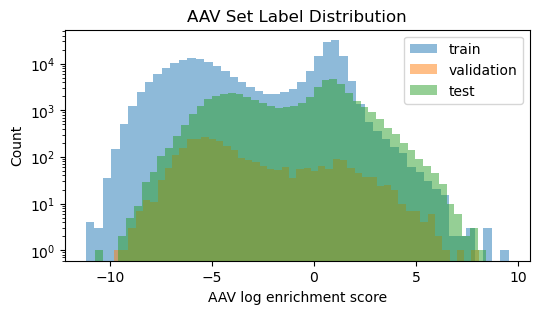

In [100]:
# Print dataset info
print("train dataset size", AAV_train_df.size)
print("validation dataset size:", AAV_valid_df.size)
print("test dataset size:", AAV_test_df.size)
AAV_train_df.head()

# Visualize label distribution
from matplotlib import pyplot as plt
plt.figure(figsize=(6,3))
plt.hist(AAV_train_df.label, bins=50, alpha=0.5, label='train')
plt.hist(AAV_valid_df.label, bins=50, alpha=0.5, label='validation')
plt.hist(AAV_test_df.label, bins=50, alpha=0.5, label='test')
plt.legend()
plt.yscale("log")
plt.xlabel("AAV log enrichment score")
plt.ylabel("Count")
plt.title("AAV Set Label Distribution") 

In [101]:
# Save to csv files
os.makedirs("training_data/aav", exist_ok=True)
AAV_train_df.to_csv("training_data/aav/aav_seq_regression_train.csv",index=False)
AAV_valid_df.to_csv("training_data/aav/aav_seq_regression_validation.csv",index=False)
AAV_test_df.to_csv("training_data/aav/aav_seq_regression_test.csv",index=False)

# Sequence Classification Example Data Preparation

Subcellular location dataset from https://github.com/J-SNACKKB/FLIP/tree/main/splits/scl

"
The six SCL (SubCellularLocation) splits stems from a 2021 publication (based on a 2017 publication) and a 2022 publicaiton which aim at predicting protein subcellular location.

The possible subcellular localizations (in the splits, assigned to TARGET) are Cytoplasm, Nucleus, Cell membrane, Mitochondrion, Endoplasmic reticulum, Lysosome/Vacuole, Golgi apparatus, Peroxisome, Extracellular and Plastid.
"



In [102]:
# Download the zip file from GitHub
SCL_URL = 'https://github.com/J-SNACKKB/FLIP/raw/main/splits/scl/splits.zip'
SCL_FILENAME = 'splits/mixed_soft.csv'
SCL_train_df, SCL_valid_df, SCL_test_df = download_data(SCL_URL, SCL_FILENAME)

In [103]:
# Map string labels to integer IDs
label2id = {label: idx for idx, label in enumerate(sorted(SCL_train_df.label.unique()))}
SCL_train_df['label'] = SCL_train_df['label'].map(label2id)
SCL_valid_df['label'] = SCL_valid_df['label'].map(label2id)
SCL_test_df['label'] = SCL_test_df['label'].map(label2id)

train dataset size 19006
validation dataset size: 3356
test dataset size: 5536
       train  validation  test
label                         
0        906         161   273
1       1862         299   505
2        594          95   173
3       1322         243   393
4        238          48    70
5        214          42    64
6       1003         200   302
7       2752         476   806
8        101          23    30
9        511          91   152


,sequence,label
0,MEVLEEPAPGPGGADAAERRGLRRLLLSGFQEELRALLVLAGPAFL...,0
1,MMKTLSSGNCTLNVPAKNSYRMVVLGASRVGKSSIVSRFLNGRFED...,0
2,MAKRTFSNLETFLIFLLVMMSAITVALLSLLFITSGTIENHKDLGG...,0
3,MGNCQAGHNLHLCLAHHPPLVCATLILLLLGLSGLGLGSFLLTHRT...,0
4,MDPSKQGTLNRVENSVYRTAFKLRSVQTLCQLDLMDSFLIQQVLWR...,0


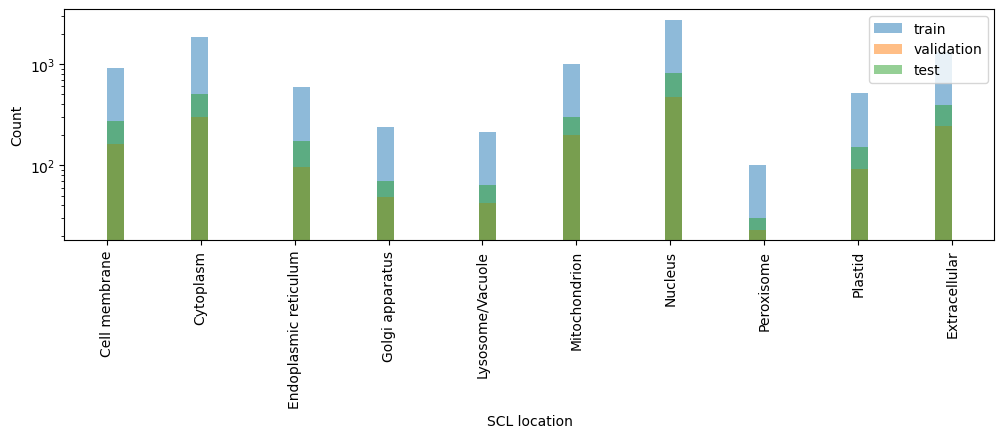

In [104]:
# Print dataset size
print("train dataset size", SCL_train_df.size)
print("validation dataset size:", SCL_valid_df.size)
print("test dataset size:", SCL_test_df.size)

# Print label distribution
# Create a DataFrame with label distributions for each split
label_dist = pd.DataFrame({
    'train': SCL_train_df['label'].value_counts().sort_index(),
    'validation': SCL_valid_df['label'].value_counts().sort_index(),
    'test': SCL_test_df['label'].value_counts().sort_index()
}).fillna(0).astype(int)
print(label_dist)

# Visualize label distribution
from matplotlib import pyplot as plt
id2label = {v: k for k, v in label2id.items()}
plt.figure(figsize=(12,3))
plt.hist(SCL_train_df.label.map(id2label), bins=50, alpha=0.5, label='train')
plt.hist(SCL_valid_df.label.map(id2label), bins=50, alpha=0.5, label='validation')
plt.hist(SCL_test_df.label.map(id2label), bins=50, alpha=0.5, label='test')
plt.legend()
plt.yscale("log")
plt.xticks(rotation=90)
plt.xlabel("SCL location")
plt.ylabel("Count")

# Print first few rows of training data
SCL_train_df.head()

In [105]:
# Save to csv files
os.makedirs("training_data/scl", exist_ok=True)
SCL_train_df.to_csv("training_data/scl/scl_seq_classification_train.csv",index=False)
SCL_valid_df.to_csv("training_data/scl/scl_seq_classification_validation.csv",index=False)
SCL_test_df.to_csv("training_data/scl/scl_seq_classification_test.csv",index=False)

# Token Classification Data Preparation Example

Secondary structure prediction from https://github.com/J-SNACKKB/FLIP/tree/main/splits/secondary_structure

"
The secondary structure split stem from three different publications, cited at the end, which aims at predicting the conservation score of the residues of a protein sequence. This is a well-known dataset and it is used to validate the behavior of code and models. Only provided a sampled split for this purpose.

There are 9712 proteins for training, 1080 proteins for validation and 648 proteins for testing.

`sampled`: Randomly split sequences into train/test with 95/5% probability.
"

Label for each sequence is a list of integers representing the secondary structure class for each residue in the sequence. The classes are represented as follows:
- 0: Coil (C)
- 1: Strand (E)
- 3: Helix (H)
Some sequences may contain residues with unknown secondary structure, represented by the label 999. These residues should be ignored during training and evaluation.

In [109]:
from Bio import SeqIO
import tempfile

# Download the zip file from GitHub
SS_URL = 'https://github.com/J-SNACKKB/FLIP/raw/main/splits/secondary_structure/splits.zip'

# The structure of this dataset is different, so we handle it separately. 
# Adapted from RSchmirler et al. 

response = requests.get(SS_URL)
zip_file = zipfile.ZipFile(BytesIO(response.content))

# Extract the fasta file to a temporary directory
# Sequence File
with tempfile.TemporaryDirectory() as temp_dir:
    zip_file.extract('splits/sequences.fasta', temp_dir)

    # Load the fasta files
    fasta_file = open(temp_dir + '/splits/sequences.fasta')
    
    # Load FASTA file using Biopython
    sequences = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences.append([record.name, str(record.seq)])

    # Create dataframe
    df = pd.DataFrame(sequences, columns=["name", "sequence"])

# Mask File
with tempfile.TemporaryDirectory() as temp_dir:
    zip_file.extract('splits/mask.fasta', temp_dir)

    # Load the fasta files
    fasta_file = open(temp_dir + '/splits/mask.fasta')
    
    # Load FASTA file using Biopython
    sequences = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences.append([str(record.seq)])

    # Add to dataframe
    df = pd.concat([df, pd.DataFrame(sequences, columns=["mask"])], axis=1) 
    
# Label File
with tempfile.TemporaryDirectory() as temp_dir:
    zip_file.extract('splits/sampled.fasta', temp_dir)

    # Load the fasta files
    fasta_file = open(temp_dir + '/splits/sampled.fasta')
    
    # Load FASTA file using Biopython
    sequences = []
    for record in SeqIO.parse(fasta_file, "fasta"):

        sequences.append([str(record.seq), record.description])

    # Add to dataframe
    df = pd.concat([df, pd.DataFrame(sequences, columns=[ "label", "dataset"])], axis=1)  

df.head()

,name,sequence,mask,label,dataset
0,1es5-A,VTKPTIAAVGGYAMNNGTGTTLYTKAADTRRSTGSTTKIMTAKVVL...,0011111111111111111111111111111111111111111111...,CCCCCCCCCEEEEEECCCCCEEEEECCCCCECCHHHHHHHHHHHHH...,1es5-A SET=train VALIDATION=False
1,2a6h-E,MAEPGIDKLFGMVDSKYRLTVVVAKRAQQLLRHGFKNTVLEPEERP...,0111111111111111111111111111111111111111111111...,CCCCCHHHHHHHCCCHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCC...,2a6h-E SET=train VALIDATION=False
2,5b1a-P,MTHQTHAYHMVNPSPWPLTGALSALLMTSGLTMWFHFNSMTLLMIG...,0011111111111111111111111111111111111111111111...,CCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHCCCCHHHHHH...,5b1a-P SET=train VALIDATION=False
3,5ehi-C,GTGSQGETLGEKWKKKLNQLSRKEFDLYKKSGITEVDRTEAKEGLK...,0000001111111111111111111111111111111111111111...,CCCCCCCCHHHHHHHHHHCCCHHHHHHHHHCCCEEEECHHHHHHHC...,5ehi-C SET=train VALIDATION=False
4,5egf-A,HHHHHHAVAKDSTESKSWEPFSLSPIKDPQALHAALCSKNVIPVTS...,0000000000000000011111111111111111111111111111...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHHHHHHHHCCCCCCCC...,5egf-A SET=train VALIDATION=False


In [110]:
# Get data split information
df["validation"]=df.dataset.str.split("=").str[2]
df["test"]=df.dataset.apply(lambda s: s.split("=")[1].split(" ")[0]=='test')

# str to bool
df['validation'] = df['validation'].apply(lambda x: x == 'True')

# Extract data split information
df["dataset"]=df.dataset.str.split("=").str[1]
df["dataset"]=df.dataset.str.split(" ").str[0]

# Preprocess mask and label to lists
# C is class 0, E is class 1, H is class 2
label2id = {"C":0, "E":1, "H":2}
df['label'] = df['label'].map(lambda x: [label2id[char] for char in x])

# str to integer for mask
df['mask'] = df['mask'].apply(lambda x: [int(i) for i in x])

# Set masked positions to -100 in label for loss calculation
df['label'] = df.apply(lambda row: [999 if m == 0 else l for l, m in zip(row['label'], row['mask'])], axis=1)

# Split the data into train, validation, and test sets
ss_test_df = df[df.test==True].reset_index(drop=True)[["sequence","label"]]
ss_train_df = df[(df.test==False) & (df.validation==False)].reset_index(drop=True)[["sequence","label"]]
ss_valid_df = df[(df.test==False) & (df.validation==True)].reset_index(drop=True)[["sequence","label"]]


In [111]:
# Print dataset info
print("train dataset size", ss_train_df.size)
print("validation dataset size:", ss_valid_df.size)
print("test dataset size:", ss_test_df.size)

# Show examples
ss_train_df.head(3)

train dataset size 19424
validation dataset size: 2160
test dataset size: 728


,sequence,label
0,VTKPTIAAVGGYAMNNGTGTTLYTKAADTRRSTGSTTKIMTAKVVL...,"[999, 999, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,..."
1,MAEPGIDKLFGMVDSKYRLTVVVAKRAQQLLRHGFKNTVLEPEERP...,"[999, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0..."
2,MTHQTHAYHMVNPSPWPLTGALSALLMTSGLTMWFHFNSMTLLMIG...,"[999, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


/var/folders/m5/06ygh2w51q56f946wtx9dfdw0000gn/T/ipykernel_30477/1517199813.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([percentages[:, 0], percentages[:, 1], percentages[:, 2]], labels=['Coil (C)', 'Strand (E)', 'Helix (H)'])


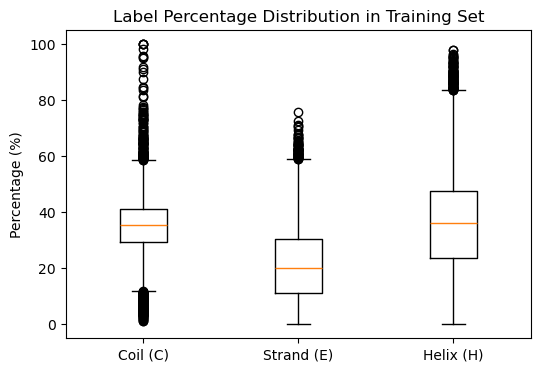

/var/folders/m5/06ygh2w51q56f946wtx9dfdw0000gn/T/ipykernel_30477/1517199813.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([percentages[:, 0], percentages[:, 1], percentages[:, 2]], labels=['Coil (C)', 'Strand (E)', 'Helix (H)'])


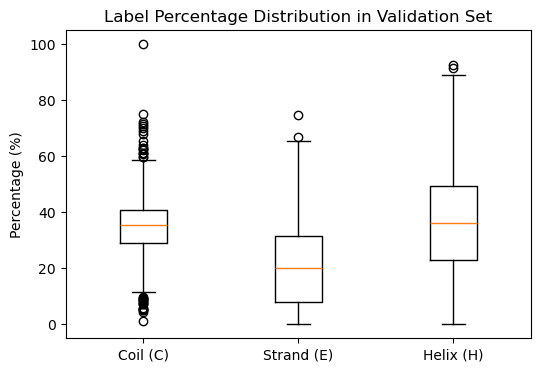

/var/folders/m5/06ygh2w51q56f946wtx9dfdw0000gn/T/ipykernel_30477/1517199813.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([percentages[:, 0], percentages[:, 1], percentages[:, 2]], labels=['Coil (C)', 'Strand (E)', 'Helix (H)'])


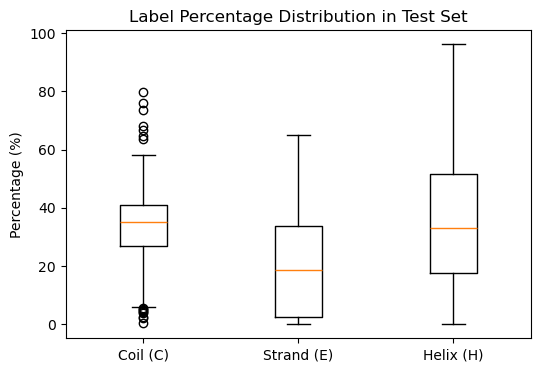

In [112]:
# Visualize per sequence label percentage distribution
import numpy as np
def plot_label_percentage_distribution(df, split_name):
    percentages = []
    for labels in df['label']:
        total = len(labels)
        counts = np.bincount([l for l in labels if l != 999], minlength=3)
        percents = counts / total * 100
        percentages.append(percents)
    percentages = np.array(percentages)

    plt.figure(figsize=(6, 4))
    plt.boxplot([percentages[:, 0], percentages[:, 1], percentages[:, 2]], labels=['Coil (C)', 'Strand (E)', 'Helix (H)'])
    plt.ylabel('Percentage (%)')
    plt.title(f'Label Percentage Distribution in {split_name} Set')
    plt.show()
plot_label_percentage_distribution(ss_train_df, 'Training')
plot_label_percentage_distribution(ss_valid_df, 'Validation')
plot_label_percentage_distribution(ss_test_df, 'Test')

In [113]:
# Save to csv files
os.makedirs("training_data/ss", exist_ok=True)
ss_train_df.to_csv("training_data/ss/ss_token_classification_train.csv",index=False)
ss_valid_df.to_csv("training_data/ss/ss_token_classification_validation.csv",index=False)
ss_test_df.to_csv("training_data/ss/ss_token_classification_test.csv",index=False)

# Token Regression Example Data Preparation
The SETH dataset quantifies residue disorder from NMR chemical shifts. This dataset originates from the CheZOD1174 subset of the SETH project (Ilz et al., Front. Bioinform. 2022). Each entry represents one protein sequence, and each amino acid in that sequence has a numerical score quantifying its structural order or disorder, derived from NMR chemical shift data.
* Low disorder score → ordered residue (stable secondary structure)
* High disorder score → intrinsically disordered residue or flexible region

For each residue, SETH computes a Z-score of the observed NMR chemical shift deviation from typical structured values.

The resulting value is continuous:

Low score (≈ 0 – 8) → Residue is disordered or flexible.

High score (> 8) → Residue is ordered (in secondary structure like α-helix or β-sheet).

Some residues have missing experimental data, so they’re marked with 999.

In [114]:
import pandas as pd
import torch
from typing import Tuple, Dict, List
from io import StringIO
import requests
from Bio import SeqIO
from sklearn.model_selection import train_test_split

CHEZOD_SEQ_URL = "https://raw.githubusercontent.com/DagmarIlz/SETH/main/datasets/CheZOD1174_training_set_sequences.fasta"
CHEZOD_SCORE_URL = "https://raw.githubusercontent.com/DagmarIlz/SETH/main/datasets/CheZOD1174_training_set_CheZOD_scores.txt"

def _download_text(url: str, timeout: int = 30) -> str:
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    return r.text

def _load_fasta_as_df(fasta_text: str) -> pd.DataFrame:
    records = [
        {"name": rec.name, "sequence": str(rec.seq)}
        for rec in SeqIO.parse(StringIO(fasta_text), "fasta")
    ]
    if not records:
        raise ValueError("No FASTA records found.")
    return pd.DataFrame.from_records(records)

def _parse_scores_txt(scores_text: str) -> pd.DataFrame:
    """
    File format (one per line):
      <name>:\t<val1>, <val2>, ..., <valN>
    """
    names: List[str] = []
    labels: List[List[float]] = []
    for line in scores_text.strip().splitlines():
        # robust split: split once on ':\t' if present; else fall back to ':' then tab
        if ":\t" in line:
            left, _, right = line.partition(":\t")
        else:
            # fallback: split on first colon or tab
            if ":" in line:
                left, _, right = line.partition(":")
            elif "\t" in line:
                left, _, right = line.partition("\t")
            else:
                raise ValueError(f"Unrecognized score line format: {line}")
        names.append(left.strip())
        # allow spaces after commas; filter out empties
        vals = [v.strip() for v in right.split(",") if v.strip() != ""]
        labels.append([float(v) for v in vals])
    return pd.DataFrame({"name": names, "label": labels})

def _mask_invalid(labels: List[float], pad_value: float = 999) -> List[float]:
    # CheZOD uses >900 to indicate missing; convert to pad_value
    return [pad_value if (x is None or x != x or x > 900) else x for x in labels]  # x!=x catches NaN

def load_chezod_train_valid(test_size: float = 0.1, seed: int = 42, pad_value: float = 999
                            ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # 1) Download
    fasta_text = _download_text(CHEZOD_SEQ_URL)
    scores_text = _download_text(CHEZOD_SCORE_URL)

    # 2) Parse
    seq_df = _load_fasta_as_df(fasta_text)                     # columns: name, sequence
    score_df = _parse_scores_txt(scores_text)                  # columns: name, label (list[float])

    # 3) Join on name; verify 1:1 mapping
    df = seq_df.merge(score_df, on="name", how="inner")
    if len(df) != len(seq_df):
        missing = set(seq_df["name"]) - set(score_df["name"])
        if missing:
            raise ValueError(f"{len(missing)} sequences have no labels, e.g. {list(sorted(missing))[:3]}")

    # 4) Validate lengths and mask invalids
    bad = []
    sequences, labels = [], []
    for _, row in df.iterrows():
        seq, lab = row["sequence"], row["label"]
        if len(seq) != len(lab):
            bad.append(row["name"])
            continue
        labels.append(_mask_invalid(lab, pad_value))
        sequences.append(seq)

    if bad:
        raise ValueError(f"{len(bad)} entries had mismatched sequence/label lengths: {bad[:3]} ...")

    tidy = pd.DataFrame({"sequence": sequences, "label": labels})

    # 5) Split
    train_df, temp_df = train_test_split(tidy, test_size=0.3, random_state=seed, shuffle=True)
    valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=seed, shuffle=True)
    train_df = train_df.reset_index(drop=True)
    valid_df = valid_df.reset_index(drop=True)
    test_df  = test_df.reset_index(drop=True)

    return train_df, valid_df, test_df

In [115]:
od_train, od_valid, od_test = load_chezod_train_valid()

In [116]:
# Print dataset info
print("CheZOD train size:", od_train.size)
print("CheZOD valid size:", od_valid.size)
print("CheZOD test size:", od_test.size)
od_train.head()

CheZOD train size: 1642
CheZOD valid size: 352
CheZOD test size: 354


,sequence,label
0,RTNQAGLELIGNAEGCRRDPYMCPAGVWTDGIGNTHGVTPGVRKTD...,"[999, 11.949, 14.319, 13.721, 13.014, 13.399, ..."
1,GSSGSSGVTGDRAGGRSWCLRRVGMSAGWLLLEDGCEVTVGRGFGV...,"[999, 999, 999, 999, 999, 999, 0.054, 0.04, 0...."
2,GAMGPTDQDWIGCAVSIACDEVLGVFQGLIKQISAEEITIVRAFRN...,"[999, 1.207, 2.435, 3.404, 7.099, 8.819, 11.08..."
3,ENLYFQGVDMPSETPQAEVGPTGCPHRSGPHSAKGSLEKGSPEDKEAKE,"[999, 4.168, 4.051, 3.028, 1.135, 2.054, 2.836..."
4,GSSEEESFFVQVHDVSPEQPLTVIKAPRVSTAQDVIQQTLCKAKYS...,"[999, 999, 5.546, 6.724, 7.742, 9.579, 12.273,..."


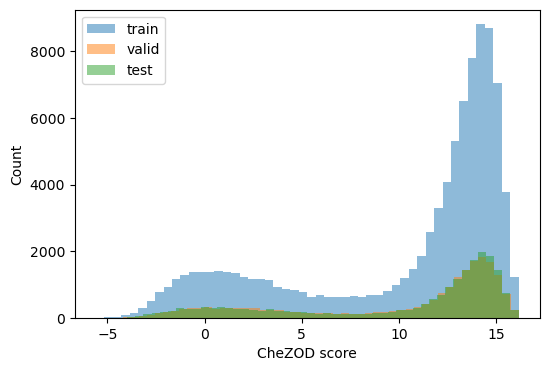

In [117]:
# Visualize the label distribution, overlaying all residues from all sequences
import matplotlib.pyplot as plt
def plot_label_distribution(df, split_name, ax):
    all_labels = [label for sublist in df['label'] for label in sublist if label != 999]
    ax.hist(all_labels, bins=50, alpha=0.5, label=split_name)
    ax.set_xlabel("CheZOD score")
    ax.set_ylabel("Count")
    ax.legend()
fig, ax = plt.subplots(figsize=(6,4))
plot_label_distribution(od_train, 'train', ax)
plot_label_distribution(od_valid, 'valid', ax)
plot_label_distribution(od_test, 'test', ax)

In [118]:
# Save prepared data to CSV files
import os
os.makedirs("training_data/chezod", exist_ok=True)
od_train.to_csv("training_data/chezod/chezod_token_regression_train.csv",index=False)
od_valid.to_csv("training_data/chezod/chezod_token_regression_validation.csv",index=False)
od_test.to_csv("training_data/chezod/chezod_token_regression_test.csv",index=False)